- Nome: Bernardo Dutra Lemos
- Matricula: 2022043949

O trabalho em questão consiste em analisar o desempenho de algum modelo de linguagem para a tarefa de POS Tagging. O modelo escolhido foi o postagger-portugues, que é um finetunning do BERTimbau, que, por sua vez, nada mais é que uma versão do BERT treinado com o vocabulário portugues. Esse postagger foi treinado com o corpus MaxMorpho, que é o mesmo da documentação do Trabalho Prático 

Eu tentei fazer o finetunning do BERTimbau localmente, entretanto estava super demorado(cerca de 19 horas por epoca), e optei por usar esse modelo já treinado e fazer a validação dele usando os dados de teste.

# Importando o modelo da biblioteca "transformers"

In [17]:
from transformers import pipeline
from tqdm import tqdm
import re

2025-01-23 11:28:51.766252: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 11:28:52.137267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 11:28:52.137383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 11:28:52.206634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 11:28:52.312109: I tensorflow/core/platform/cpu_feature_guar

In [18]:
pipe = pipeline("token-classification", model="lisaterumi/postagger-portuguese",aggregation_strategy=None)

/home/bdlemos/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fazendo teste com frase aleatória para identificar o formato da saída

In [19]:
pipe('Salto sete .')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'N',
  'score': 0.7346732,
  'index': 1,
  'word': 'Sal',
  'start': 0,
  'end': 3},
 {'entity': 'N',
  'score': 0.61871666,
  'index': 2,
  'word': '##to',
  'start': 3,
  'end': 5},
 {'entity': 'N',
  'score': 0.9268626,
  'index': 3,
  'word': 'sete',
  'start': 6,
  'end': 10},
 {'entity': 'PU',
  'score': 0.99989283,
  'index': 4,
  'word': '.',
  'start': 11,
  'end': 12}]

# Funções de tratamento dos dados

In [20]:
def tratamento_dados(conteudo):
    frases = conteudo.split('\n')
    frases = [frase.split(' ') for frase in frases if len(frase) > 1]
    frases = [[palavra.split('_') for palavra in frase] for frase in frases]
    return frases

Conhecendo formato das frases no arquivo de entrada

In [21]:
with open('macmorpho-test.txt', 'r', encoding='utf-8') as file:
    conteudo = file.read()
print(conteudo[:17])

Salto_N sete_ADJ



In [22]:
tratamento_dados(conteudo[:18])

[[['Salto', 'N'], ['sete', 'ADJ']]]

# Rodando os testes e salvando as prediçoes

In [23]:
data_test = tratamento_dados(conteudo)

predicts = []

for frase in tqdm(data_test):
    # Coloca a frase em formato de string para passar para o modelo
    frase = [palavra for palavra,_ in frase]
    frase = " ".join(frase)
    # Substitui vírgula por ponto nos numeros decimais
    frase = re.sub(r'(\d+),(\d+)', r'\1.\2', frase)
    # Faz a predição da frase
    pred = pipe(frase)
    predicts.append(pred)

100%|██████████| 9987/9987 [13:03<00:00, 12.74it/s]


Recuperando as labels

In [24]:
labels = [[token for _,token in palavras] for palavras in data_test]

# Analisando resultados

## Funçoes para colocar predições no mesmo formato que labels

Como o tokenizer do modelo quebra palavras em mais de um token e da uma predição para cada um, é preciso junta-los novamente <br> e a forma como fiz isso é pegando todos os subtokens de uma palavra e pegando a predição de maior score.

In [25]:
def reconstruct_words(predictions):
    reconstructed = []
    current_word = ""
    current_entities = []
    
    for pred in predictions:
        word = pred['word']
        entity = pred['entity']
        score = pred['score']

        if word.startswith("##"):
            current_word += word[2:]  # Remove "##" e junta com a palavra anterior
        else:
            if current_word:  # Salvar a palavra anterior antes de iniciar uma nova
                reconstructed.append({"word": current_word, "entities": current_entities})
            current_word = word  # Inicia uma nova palavra
            current_entities = []
        
        current_entities.append({"entity": entity, "score": score})
    
    # Adiciona a última palavra processada
    if current_word:
        reconstructed.append({"word": current_word, "entities": current_entities})
    
    return reconstructed


In [26]:
def align_predictions_with_labels(predictions, labels):
    """
    Compara previsões reconstruídas com as etiquetas reais.
    """
    aligned_predictions = []
    aligned_labels = []

    for pred_sentence, label_sentence in zip(predictions, labels):
        pred_words = reconstruct_words(pred_sentence)
        # print(pred_words)
        label_words = label_sentence

        # Verifica alinhamento palavra a palavra
        for i, label_word in enumerate(label_words):
            score = 0
            pred_entity = ""
            for val in pred_words[i]["entities"]:
            # pred_entity = pred_words[i]["entities"][0]["entity"]  # Usar apenas a primeira entidade para simplificação
                if val['score'] >= score:
                    pred_entity = val["entity"]
                    score = val["score"]
            aligned_predictions.append(pred_entity)
            # print(pred_words[i]["entities"][0]["entity"])
            aligned_labels.append(label_word)  # Etiqueta da palavra

    return aligned_predictions, aligned_labels


## Análise de resultados

In [41]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

aligned_predictions, aligned_labels = align_predictions_with_labels(predicts, labels)

# Relatório de métricas
# print(classification_report(aligned_labels, aligned_predictions))
metrics_df = pd.DataFrame(classification_report(aligned_labels, aligned_predictions, output_dict=True)).drop(['macro avg', 'accuracy', 'weighted avg'],axis=1).T

metrics_df.sort_values(by='support', ascending=False)

/home/bdlemos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bdlemos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bdlemos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
N,0.864998,0.847600,0.856211,36542.0
PU,0.877996,0.865856,0.871884,26904.0
V,0.920179,0.918218,0.919198,19711.0
PREP,0.863435,0.872750,0.868068,16778.0
NPROP,0.883915,0.877259,0.880574,15936.0
ART,0.900175,0.901749,0.900961,12580.0
PREP+ART,0.870968,0.863979,0.867459,10219.0
ADJ,0.848369,0.854220,0.851284,8554.0
ADV,0.863506,0.829416,0.846118,5446.0
KC,0.846764,0.848819,0.847790,4531.0


In [ ]:
metrics = classification_report(aligned_labels, aligned_predictions, output_dict=True);

/home/bdlemos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bdlemos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bdlemos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


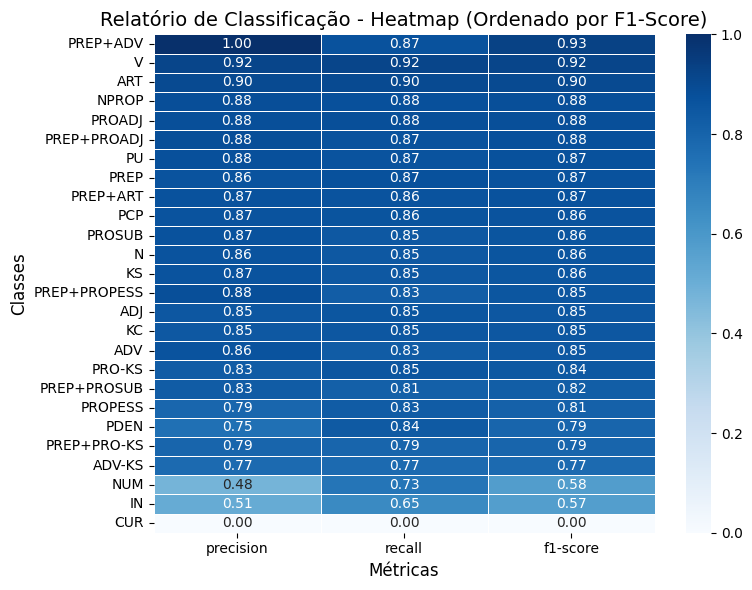

In [33]:

metrics_df = pd.DataFrame(metrics).iloc[:-1, :].T  # Excluir a última linha (suporte)

metrics_df = metrics_df.sort_values(by='f1-score', ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df.drop(['macro avg', 'accuracy', 'weighted avg']), annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, cbar=True)

# Adicionar título e rótulos
plt.title("Relatório de Classificação - Heatmap (Ordenado por F1-Score)", fontsize=14)
plt.xlabel("Métricas", fontsize=12)
plt.ylabel("Classes", fontsize=12)

plt.tight_layout()
plt.show()


In [34]:
metrics_df.loc[['accuracy', 'macro avg', 'weighted avg'], :]

,precision,recall,f1-score
accuracy,0.865047,0.865047,0.865047
macro avg,0.797959,0.806468,0.800470
weighted avg,0.866890,0.865047,0.865504


In [35]:
for frase in tqdm(data_test[123:126]):
    l = [token for _,token in frase]
    frase = [palavra for palavra,_ in frase]
    frase = " ".join(frase)
    frase = re.sub(r'(\d+),(\d+)', r'\1.\2', frase)
    pred = pipe(frase)
    print(frase)
    print([i['entity'] for i in pred])
    print(l)

100%|██████████| 3/3 [00:00<00:00, 14.07it/s]

Os africanos trouxeram a linguagem e o culto do corpo .
['ART', 'N', 'V', 'ART', 'N', 'KC', 'ART', 'N', 'PREP+ART', 'N', 'PU']
['ART', 'N', 'V', 'ART', 'N', 'KC', 'ART', 'N', 'PREP+ART', 'N', 'PU']
O latino , tupi , afro .
['ART', 'N', 'PU', 'N', 'PU', 'N', 'PU']
['ART', 'N', 'PU', 'N', 'PU', 'N', 'PU']
" Ao lado da velha representação romântica do 19 o índio é sempre tupi - estava evidente a exaltação de um sincretismo que de biológico e racial se faz cultural e social .
['PU', 'PREP+ART', 'N', 'PREP+ART', 'ADJ', 'N', 'ADJ', 'PREP+ART', 'NUM', 'ART', 'N', 'N', 'V', 'ADV', 'N', 'PU', 'V', 'ADJ', 'ART', 'N', 'N', 'PREP', 'ART', 'N', 'N', 'N', 'PRO-KS', 'PREP', 'ADJ', 'KC', 'ADJ', 'PROPESS', 'V', 'ADJ', 'KC', 'ADJ', 'PU']
['PU', 'PREP+ART', 'N', 'PREP+ART', 'ADJ', 'N', 'ADJ', 'PREP+ART', 'N', 'ART', 'N', 'V', 'ADV', 'N', 'PU', 'V', 'ADJ', 'ART', 'N', 'PREP', 'ART', 'N', 'PRO-KS', 'PREP', 'ADJ', 'KC', 'ADJ', 'PROPESS', 'V', 'ADJ', 'KC', 'ADJ', 'PU']


# Conclusões

**Pontos Positivos:**

* **Desempenho em classes frequentes:** O modelo demonstrou excelência ao identificar substantivos (N), artigos (ART), nomes próprios (NPROP), verbos (V) e pronomes (PU). A alta precisão e recall nessas classes, que compõem a maior parte do corpus, contribuíram significativamente para a acurácia geral de 87%.
* **Mapeando relações complexas:** O modelo mostrou-se capaz de reconhecer combinações de preposições com artigos (PREP+ART), adjetivos (PREP+PROADJ) e pronomes pessoais (PREP+PROPESS), indicando uma boa compreensão de relações mais complexas entre palavras.
* **Equilíbrio entre classes:** A métrica weighted average confirma a robustez do modelo, demonstrando um bom desempenho em classes com diferentes frequências, evitando o viés para as classes mais comuns.

**Pontos de Melhoria:**

* **Classes com poucos exemplos:** Classes como moedas (CUR), interjeições (IN) e combinações menos frequentes de preposições com pronomes ou advérbios apresentaram dificuldades, possivelmente devido à escassez de dados de treinamento.
* **Distinção entre números e substantivos:** O modelo teve problemas em diferenciar números (NUM) de substantivos (N) e advérbios (ADV), indicando a necessidade de aprimorar a representação dessas classes.
* **Classes compostas raras:** Combinações de preposições com advérbios conjuntivos subordinados (PREP+ADV-KS) e pronomes conjuntivos subordinados (PREP+PRO-KS) apresentaram resultados instáveis, sugerindo que mais dados são necessários para confirmar esses resultados.
* **Impacto do desbalanceamento:** A alta frequência de substantivos e pronomes pode ter mascarado dificuldades em outras classes, exigindo uma análise mais detalhada do desempenho do modelo em cada categoria.

